## Time Series Prediction of IBM Stock Prices with a Simple RNN
This notebook aims to leverage the power of recurrent neural networks (RNNs) to predict the closing stock prices of IBM. We exploit the historical trends and patterns inherent in financial market data to build and train our RNN model, a task that recurrent networks are naturally suited for, given their ability to maintain a sort of "memory" of past information.

The dataset used for this analysis is publicly available on Kaggle and contains historical stock prices for IBM. It can be accessed through the following link: https://www.kaggle.com/datasets/bhanuprasanna527/stock-market-prediction. The data includes various attributes like 'Low', 'Open', 'Volume', 'High', 'Close', and 'Adjusted Close' recorded over several years. For the scope of this model, we will focus solely on the 'Close' column, which represents the closing price of the stock each day.

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import torch 
import numpy as np
import plotly
from torch import nn
from sklearn.model_selection import train_test_split

In [52]:
df = pd.read_csv('IBM.csv')
print(df)

            Date    Open    High     Low   Close    Volume Name
0     2006-01-03   82.45   82.55   80.81   82.06  11715200  IBM
1     2006-01-04   82.20   82.50   81.33   81.95   9840600  IBM
2     2006-01-05   81.40   82.90   81.00   82.50   7213500  IBM
3     2006-01-06   83.95   85.03   83.41   84.95   8197400  IBM
4     2006-01-09   84.10   84.25   83.38   83.73   6858200  IBM
...          ...     ...     ...     ...     ...       ...  ...
3015  2017-12-22  151.82  153.00  151.50  152.50   2990583  IBM
3016  2017-12-26  152.51  153.86  152.50  152.83   2479017  IBM
3017  2017-12-27  152.95  153.18  152.61  153.13   2149257  IBM
3018  2017-12-28  153.20  154.12  153.20  154.04   2687624  IBM
3019  2017-12-29  154.17  154.72  153.42  153.42   3327087  IBM

[3020 rows x 7 columns]


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3020 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3020 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3020 non-null   float64
 5   Volume  3020 non-null   int64  
 6   Name    3020 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.3+ KB


In [54]:
df['Date'] = pd.to_datetime(df['Date'])

In [55]:
df.set_index('Date',inplace=True)

In [56]:
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [57]:
df.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,151.82,153.00,151.50,152.50,2990583,IBM
2017-12-26,152.51,153.86,152.50,152.83,2479017,IBM
2017-12-27,152.95,153.18,152.61,153.13,2149257,IBM
2017-12-28,153.20,154.12,153.20,154.04,2687624,IBM
2017-12-29,154.17,154.72,153.42,153.42,3327087,IBM


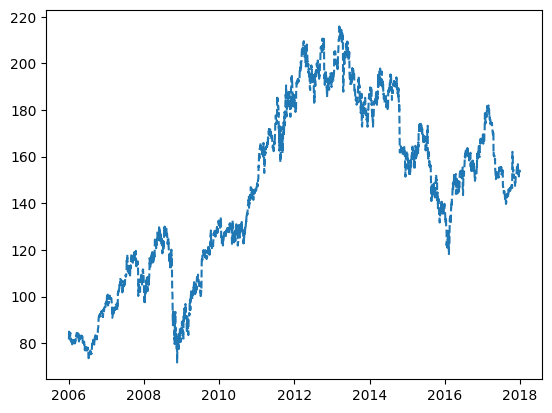

In [58]:
plt.plot(df['Close'], linestyle='--')
plt.show()

### Model Architecture
We use a simple RNN built using PyTorch. The model is structured with two main layers: an input-to-hidden layer (in_h) and an input-to-output layer (in_out). The hidden layer serves to compute the next hidden state, while the output layer computes the output.

The model follows a specific sequence: input and hidden states are concatenated and passed through the in_h layer, activated by the tanh function to compute the h_out. Next, an output is produced at each timestep using the in_out layer.

In [59]:
class VanillaRNN(nn.Module): 
    
    def __init__(self, len_in, len_h, len_out):
        super(VanillaRNN, self).__init__()
        self.len_h = len_h #size of hidden state
        self.in_h = nn.Linear(len_in + len_h, len_h) #graph module to compute next hidden state 
        self.in_out = nn.Linear(len_in + len_h, len_out) #computes output 
        self.tanh = nn.Tanh()

    def forward(self, x, h):
        #here we choose to concatenate the hidden state and input 
        #another approach would be to multiply these vectors 
        for t in range(x.size(1)):
            input = x[:,t,:]
            combined = torch.cat((input, h), 1) 
            h_out = self.tanh(self.in_h(combined)) 
            #we choose to produce an output at each timestep
            y = self.in_out(combined) 
        return y, h_out 

    def init_h(self, batch_size):
        #zero initialization 
        #alternatives include but not limited to Xavier/Kaiminh initialization
        return torch.zeros(batch_size, self.len_h, requires_grad=False)

## Training

In [60]:
def train(model, data_loader, loss_function, optim, epochs, device, scheduler, start_decay):
    
    losses = [] #group losses for loss visualization 
    
    for epoch in range(epochs):
        running_loss = 0 
        print("Epoch %d / %d" % (epoch+1, epochs))
        print("-"*10)
        if (epoch > start_decay): 
            scheduler.step()
    
        for i, (x, y) in enumerate(data_loader):
            h_s = model.init_h(x.shape[0]).to(device) 
                
            x = x.to(device)
            y = y.to(device)
            y_pred, h_out = model(x, h_s)
            # y_pred = y_pred[:, -1, :]
            h_s = h_out
            
            loss = loss_function(y_pred, y) 
            running_loss+=loss.item()
            
        
            optim.zero_grad()
            loss.backward() #backprop 
            optim.step() #update weights
  
        losses.append((running_loss / i))
        print("Step: {}/{}, current Epoch loss: {:.4f}".format(i, len(data_loader), (running_loss / i)))
        
    return losses

In [61]:
def load_data(stock, sequence_length):
    # Convert pandas dataframe to numpy array
    data_raw = stock.to_numpy()

    data = []

    # Loop over the stock data to generate sequences of 'sequence_length' consecutive data points
    # This is done because RNNs learn to predict data in a sequence from past sequence
    for index in range(len(data_raw) - sequence_length):
        data.append(data_raw[index: index + sequence_length])

    data = np.array(data)
    set_size = int(data.shape[0])

    # Generate the train data
    # x_train is all sequences excluding the last data point from each sequence
    x = data[:,:-1,:]
    # y_train is the last data point from each sequence
    y = data[:,-1,:]
    

    # Return the train and test data
    return [x, y]

In [62]:
ibm_df = pd.read_csv('IBM.csv')
ibm_df['Date'] = pd.to_datetime(ibm_df['Date'])
ibm_df.set_index('Date',inplace=True)
ibm_df = ibm_df[['Close']]

# Get the number of rows in the DataFrame
num_rows = ibm_df.shape[0]

# Compute the split point
split_point = int(num_rows*0.8)

# Split the DataFrame
train_df = ibm_df.iloc[:split_point]
test_df = ibm_df.iloc[split_point:]

x_train, y_train = load_data(train_df, 10) 
x_test, y_test = load_data(test_df, 10) 

In [63]:
print(train_df.head()) #to ensure no shuffling accidentally occurred 

            Close
Date             
2006-01-03  82.06
2006-01-04  81.95
2006-01-05  82.50
2006-01-06  84.95
2006-01-09  83.73


In [64]:
print(test_df.tail())

             Close
Date              
2017-12-22  152.50
2017-12-26  152.83
2017-12-27  153.13
2017-12-28  154.04
2017-12-29  153.42


In [65]:
print("Train input data shape: {}, target shape: {}".format(x_train.shape, y_train.shape)) 

Train input data shape: (2406, 9, 1), target shape: (2406, 1)


In [66]:
print("Test input data shape: {}, target shape: {}".format(x_test.shape, y_test.shape)) 

Test input data shape: (594, 9, 1), target shape: (594, 1)


In [67]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [68]:
train_set = torch.utils.data.TensorDataset(x_train,y_train)
test_set = torch.utils.data.TensorDataset(x_test,y_test)

In [69]:
NUM_EPOCHS = 100
BATCH_SIZE = 30 
LEARNING_RATE = 3e-4
INPUT_DIM = 1 
OUTPUT_DIM = 1 
HIDDEN_DIM = 32 

In [70]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

In [71]:
model = VanillaRNN(len_in=INPUT_DIM, len_h=HIDDEN_DIM, len_out=OUTPUT_DIM)

In [72]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
DECAY_FACTOR = 0.1
DECAY_EPOCHS = 20
START_DECAY_EPOCH = 50
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=DECAY_EPOCHS, gamma=DECAY_FACTOR)

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
model = model.to(device)

In [75]:
losses = train(model=model, data_loader=train_loader, loss_function=torch.nn.MSELoss(size_average=True), optim=optimizer, epochs=NUM_EPOCHS, device=device, scheduler=scheduler, \
    start_decay=START_DECAY_EPOCH)

/home/aryaman.pandya/ml_accel/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch 1 / 100
----------


IndexError: too many indices for tensor of dimension 2

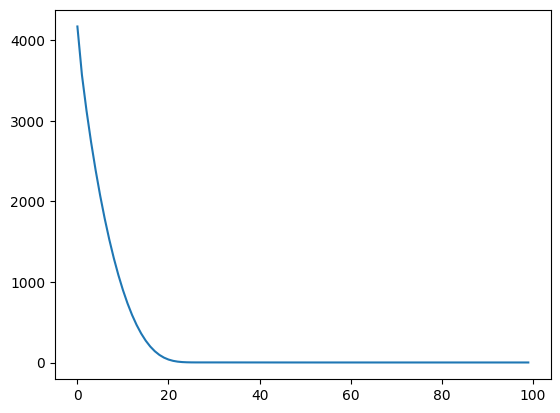

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
import plotly.graph_objects as go
epochs = list(range(len(losses)))

fig = go.Figure(data=go.Scatter(x=epochs, y=losses, mode='lines+markers', name='Train'))

fig.update_layout(title='Training Loss per Epoch',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')

fig.show()

## Evaluation

In [ ]:
targets = [] 
predicted = []

model.eval()
for i, (x, y) in enumerate(test_loader):
    h_s = model.init_h(x.shape[0], x.shape[1]).to(device) 
        
    x = x.to(device)
    y = y.to(device)
    y_pred, h_out = model(x, h_s)
    y_pred = y_pred[:, -1, :]
    predicted.append(y_pred.cpu().detach().numpy())
    targets.append(y.cpu().detach().numpy())
    h_s = h_out
    

In [ ]:
from sklearn.metrics import mean_squared_error
target_long_array = np.concatenate(targets)
predicted_long_array = np.concatenate(predicted)

mse = mean_squared_error(target_long_array, predicted_long_array)
print(f'Mean Squared Error (MSE): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 4.080652236938477
Root Mean Squared Error (RMSE): 2.0200624465942383


In [ ]:
target_list = target_long_array.tolist()
predicted_list = predicted_long_array.tolist()

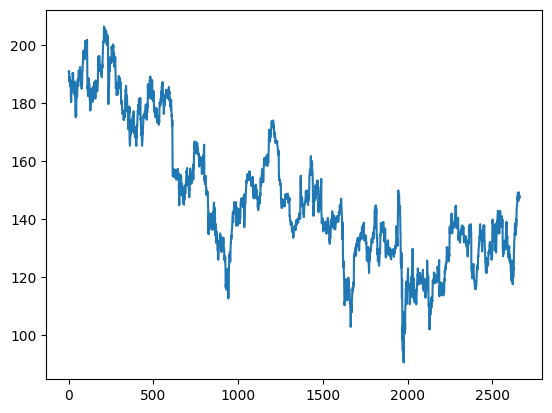

In [ ]:
plt.plot(predicted_list)
plt.show()

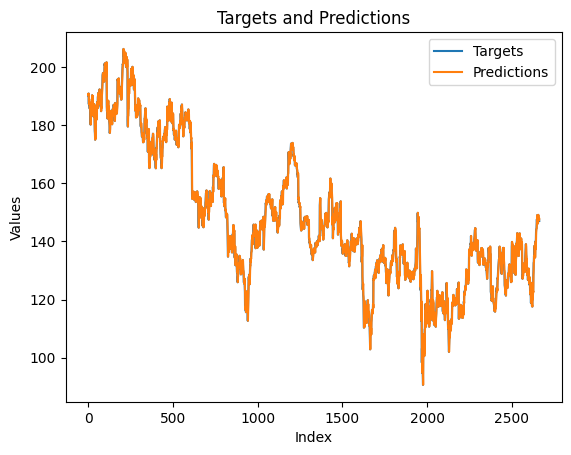

In [ ]:
fig, ax = plt.subplots()

# Add the targets and predictions to the plot
ax.plot(target_list, label='Targets')
ax.plot(predicted_list, label='Predictions')

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title('Targets and Predictions')

# Add a legend
ax.legend()

# Show the plot
plt.show()